In [1]:
import tensorflow as tf
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow import keras

In [2]:
train_dir='C:/Users/dell/Downloads/ma/Malaria Cells/training_set'
test_dir='C:/Users/dell/Downloads/ma/Malaria Cells/testing_set'


In [3]:
batch_size = 180
epochs = 10
img_height = 224
img_width = 224

In [4]:
train_image_generator = ImageDataGenerator(rescale=1./255)  
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,directory=train_dir,shuffle=True,target_size=(img_height, img_width),class_mode='categorical')

Found 27558 images belonging to 2 classes.


In [5]:
val_image_generator = ImageDataGenerator(rescale=1./255)  
val_data_gen = val_image_generator .flow_from_directory(batch_size=batch_size,directory=test_dir,shuffle=True,target_size=(img_height, img_width),class_mode='categorical')

Found 15832 images belonging to 2 classes.


In [6]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
#from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.inception_v3 import preprocess_input

In [7]:
IMAGE_SIZE = [224, 224,3]

In [8]:
base_model = InceptionV3(input_shape=IMAGE_SIZE, weights='imagenet', include_top=False)

In [9]:
base_model.trainable = False

In [10]:
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

batch_normalization_65 (BatchNo (None, 12, 12, 192)  576         conv2d_65[0][0]                  
__________________________________________________________________________________________________
activation_65 (Activation)      (None, 12, 12, 192)  0           batch_normalization_65[0][0]     
__________________________________________________________________________________________________
conv2d_61 (Conv2D)              (None, 12, 12, 192)  147456      mixed6[0][0]                     
__________________________________________________________________________________________________
conv2d_66 (Conv2D)              (None, 12, 12, 192)  258048      activation_65[0][0]              
__________________________________________________________________________________________________
batch_normalization_61 (BatchNo (None, 12, 12, 192)  576         conv2d_61[0][0]                  
__________________________________________________________________________________________________
batch_norm

In [11]:
cnn_model = keras.models.Sequential([
    base_model,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Flatten(),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(2, activation="softmax")
])

In [12]:
cnn_model.compile(optimizer='adam',
loss='categorical_crossentropy',
metrics=['accuracy'])

In [13]:
history = cnn_model.fit(train_data_gen, epochs=1,
validation_data= val_data_gen,)


154/154 [==============================] - 2856s 18s/step - loss: 0.4222 - accuracy: 0.8225 - val_loss: 0.1875 - val_accuracy: 0.9276


In [15]:
classes = {'infected': 0, 'Uninfected': 1}

In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
def test_on_img(img):
    data=[]
    image = Image.open(img)
    image = image.resize((224,224))
    data.append(np.array(image))
    X_test=np.array(data)
    Y_pred = cnn_model.predict_classes(X_test)
    return image,Y_pred

In [15]:
import numpy as np

In [16]:
y=np.concatenate([val_data_gen.next()[1] for i in range(val_data_gen.__len__())])
true_labels=np.argmax(y, axis=-1)
prediction= cnn_model.predict(val_data_gen, verbose=2)
prediction=np.argmax(prediction, axis=-1)

88/88 - 278s


In [17]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [18]:
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
cm = confusion_matrix(y_true=true_labels, y_pred=prediction)

In [19]:
cm_plot_labels = ['infected', 'Uninfected']

Confusion matrix, without normalization
[[7420  460]
 [ 687 7265]]
Accuracy: 0.928
Precision: 0.940
Recall: 0.928
F-Measure: 0.928


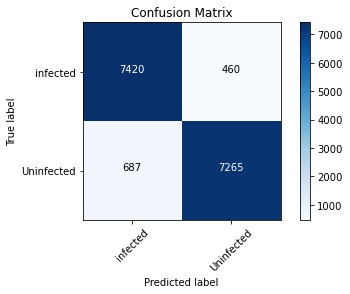

In [20]:
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')
from sklearn.metrics import accuracy_score
acc=accuracy_score(true_labels,prediction) 
print('Accuracy: %.3f' % acc)
from sklearn.metrics import precision_score
precision = precision_score(true_labels,prediction,labels=[1,2], average='micro')
print('Precision: %.3f' % precision)
from sklearn.metrics import recall_score
recall = recall_score(true_labels,prediction, average='micro')
print('Recall: %.3f' % recall)
from sklearn.metrics import f1_score
score = f1_score(true_labels,prediction, average='micro')
print('F-Measure: %.3f' % score)

In [23]:
loss, accuracy = cnn_model.evaluate(train_data_gen, verbose=1)
loss_v, accuracy_v = cnn_model.evaluate(val_data_gen, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))

88/88 [==============================] - 291s 3s/step - loss: 0.1875 - accuracy: 0.9276
Validation: accuracy = 0.927552  ;  loss_v = 0.187455
Test: accuracy = 0.931635  ;  loss = 0.180929


In [25]:
pip install graphviz

Note: you may need to restart the kernel to use updated packages.Collecting graphviz



In [26]:
 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(123)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
import itertools

import keras
from keras.utils.np_utils import to_categorical

In [14]:
cnn_model.save('save.h5')